/Users/merrickpiersonsmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


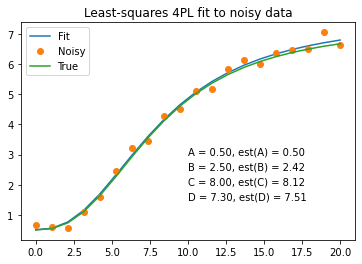

In [1]:
#Source: https://people.duke.edu/~ccc14/pcfb/analysis.html

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

def logistic4(x, A, B, C, D):
    """4PL logistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)

# Make up some data for fitting and add noise
# In practice, y_meas would be read in from a file
x = np.linspace(0,20,20)
A,B,C,D = 0.5,2.5,8,7.3
y_true = logistic4(x, A, B, C, D)
y_meas = y_true + 0.2*npr.randn(len(x))

# Initial guess for parameters
p0 = [0, 1, 1, 1]

# Fit equation using least squares optimization
plsq = leastsq(residuals, p0, args=(y_meas, x))

# Plot results
plt.plot(x,peval(x,plsq[0]),x,y_meas,'o',x,y_true)
plt.title('Least-squares 4PL fit to noisy data')
plt.legend(['Fit', 'Noisy', 'True'], loc='upper left')
for i, (param, actual, est) in enumerate(zip('ABCD', [A,B,C,D], plsq[0])):
    plt.text(10, 3-i*0.5, '%s = %.2f, est(%s) = %.2f' % (param, actual, param, est))
#plt.savefig('logistic.png')

In [2]:
import pandas as pd
std_E = pd.read_csv("standards_estradiol.csv")
std_P = pd.read_csv("standards_progesterone.csv")
std_P

,pg_mL,A450_corrected
0,40000,0.183
1,15000,0.248
2,5000,0.360
3,2500,0.511
4,1250,0.712
5,300,1.217
6,0,1.688


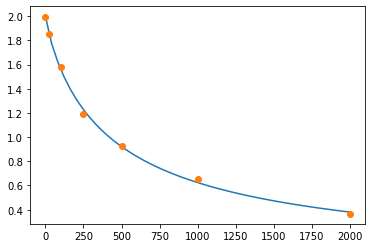

In [3]:
y1_E = std_E['A450_corrected']
x1_E = std_E['pg_mL']

guess = [2, 1, 500, 0]

fit_E = leastsq(residuals, guess, args=(y1_E, x1_E))


test = np.linspace(0,2000, 50)
test

plt.plot(test,peval(test,fit_E[0]),x1_E,y1_E,'o')
#plt.savefig('2021-10-07_standards_logistic_4param.png')

In [4]:
fit_E

(array([ 1.99890325e+00,  8.74091640e-01,  4.47975179e+02, -5.71457491e-02]),
 1)

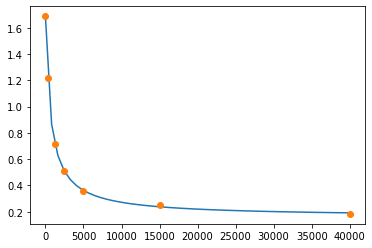

In [5]:
y1_P = std_P['A450_corrected']
x1_P = std_P['pg_mL']

guess = [2, 1, 500, 0]

fit_P = leastsq(residuals, guess, args=(y1_P, x1_P))


test = np.linspace(0,40000, 50)
test

plt.plot(test,peval(test,fit_P[0]),x1_P,y1_P,'o')
#plt.savefig('2021-10-07_standards_logistic_4param.png')

/Users/merrickpiersonsmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


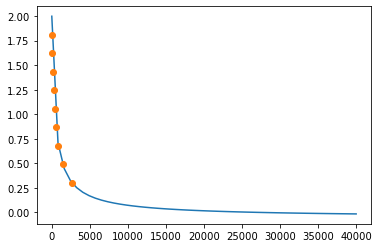

In [6]:
#Interpolate using the inverse function
#x=p(3).*(((p(1)-p(4))./(y-p(4)))-1).^(1/p(2));
def inv_logistic4(p, y): #p = model parameters
    x = p[2] * (((p[0]-p[3])/(y-p[3]))-1)**(1/p[1])
    return x

test2 = np.linspace(0.3, 2, 10)
plt.plot(test,peval(test,fit_E[0]),inv_logistic4(fit_E[0], test2),test2,'o')

In [9]:
data = pd.read_csv("data_all.csv")
data["pg_uL_estradiol"] = inv_logistic4(fit_E[0], data["A450_adj_estradiol"])
data["pg_uL_progesterone"] = inv_logistic4(fit_P[0], data["A450_adj_progesterone"])
data

,Sample,A450_adj_estradiol,A450_adj_progesterone,pg_uL_estradiol,pg_uL_progesterone
0,01_Sorted_day14,1.867,0.206,20.874008,26389.036672
1,02_D4_-RA_day14,1.884,0.259,17.647394,11424.713067
2,03_D4_+RA_day14,1.907,0.224,13.485099,18475.453961
3,04_13D7_pool_day2,2.039,0.310,NaN,7121.180108
4,05_PGCLC_Only_day2,1.946,0.519,7.009513,2401.430926
5,06_D4_day2,2.022,0.327,NaN,6281.818974
6,07_E1_day2,1.934,0.075,8.917564,NaN
7,08_F66.6_NR1_day2,2.022,0.169,NaN,143711.206762
8,09_F66.6_NR5_day2,2.064,0.498,NaN,2606.361140
9,10_F66.6_NRG3_day2,2.099,0.247,NaN,13190.889474


In [10]:
data.to_csv("2022-03-08_hormones.csv")